## Подключение библиотек и определение класса Dataset

In [81]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window, output):
        self.data = data
        self.window = window
        self.output = output

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index+self.window:index+self.window+self.output]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.output

## Определение параметров модели

In [82]:
input_size = 15
pred = input_size
learning_rate = 0.0001
output_size = 100
data_size  = 5000
step = 1
m = 10 #на сколько шагов предсказать
data_set = 10000
column_name = "HUFL"
model_name = f"fun_model_v6_L1_SGD_{column_name}_input{input_size}_output{output_size}"


## Класс деокмпозиции временного ряда для получение сезонной и трендовой составляющей

In [83]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

## Класс DLinear и функция для обучения модели

In [84]:
class DLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(input_size, output_size)
        self.linear_trend = nn.Linear(input_size, output_size)
        
        self.linear_seasonal1 = nn.Linear(output_size, output_size)
        self.linear_trend1 = nn.Linear(output_size, output_size)
        self.linear_seasonal2 = nn.Linear(output_size, output_size)
        self.linear_trend2 = nn.Linear(output_size, output_size)
        self.linear_seasonal3 = nn.Linear(output_size, output_size)
        self.linear_trend3 = nn.Linear(output_size, output_size)
        
        self.decomposition = DecompositionLayer(input_size)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        seasonal_output1 = self.linear_seasonal1(seasonal_output)
        trend_output1 = self.linear_trend1(trend_output)
        seasonal_output2 = self.linear_seasonal2(seasonal_output1)
        trend_output2 = self.linear_trend2(trend_output1)
        seasonal_output3 = self.linear_seasonal3(seasonal_output1)
        trend_output3 = self.linear_trend3(trend_output1)
        
        return seasonal_output3 + trend_output3


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        print("Epoch = ", epoch)
        for X, Y in dataloader:
            
            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()


In [85]:

data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data[column_name].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [86]:
model = DLinearModel(input_size, output_size)
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#TODO: переписать dataloader для правильно обучения

window_size = input_size  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size, output_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [87]:
len(dataloader)

4885

In [88]:
#train_model(model, dataloader, criterion, optimizer)


In [89]:
#torch.save(model.state_dict(), model_name)

In [90]:
model.load_state_dict(torch.load(model_name))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=15, out_features=100, bias=True)
  (linear_trend): Linear(in_features=15, out_features=100, bias=True)
  (linear_seasonal1): Linear(in_features=100, out_features=100, bias=True)
  (linear_trend1): Linear(in_features=100, out_features=100, bias=True)
  (linear_seasonal2): Linear(in_features=100, out_features=100, bias=True)
  (linear_trend2): Linear(in_features=100, out_features=100, bias=True)
  (linear_seasonal3): Linear(in_features=100, out_features=100, bias=True)
  (linear_trend3): Linear(in_features=100, out_features=100, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(15,), stride=(1,), padding=(0,))
  )
)

In [91]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=15, out_features=100, bias=True)
  (linear_trend): Linear(in_features=15, out_features=100, bias=True)
  (linear_seasonal1): Linear(in_features=100, out_features=100, bias=True)
  (linear_trend1): Linear(in_features=100, out_features=100, bias=True)
  (linear_seasonal2): Linear(in_features=100, out_features=100, bias=True)
  (linear_trend2): Linear(in_features=100, out_features=100, bias=True)
  (linear_seasonal3): Linear(in_features=100, out_features=100, bias=True)
  (linear_trend3): Linear(in_features=100, out_features=100, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(15,), stride=(1,), padding=(0,))
  )
)>

In [92]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [93]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)

pred = input_size
X_f = torch.tensor(data[column_name].values[data_set-pred:data_set-pred+pred*step:step], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred, output_size)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[ 14.9370],
        [ 14.8700],
        [ 14.7360],
        [ 15.0700],
        [ 13.7980],
        [ 16.0080],
        [ 13.1280],
        [  5.9610],
        [ -2.0090],
        [ -5.4250],
        [ -8.7740],
        [-10.0470],
        [ -3.9520],
        [ -5.4920],
        [ -6.0280]])
tensor([[ 14.9370],
        [ 14.8700],
        [ 14.7360],
        [ 15.0700],
        [ 13.7980],
        [ 16.0080],
        [ 13.1280],
        [  5.9610],
        [ -2.0090],
        [ -5.4250],
        [ -8.7740],
        [-10.0470],
        [ -3.9520],
        [ -5.4920],
        [ -6.0280]])


tensor([[ 14.9370],
        [ 14.8700],
        [ 14.7360],
        [ 15.0700],
        [ 13.7980],
        [ 16.0080],
        [ 13.1280],
        [  5.9610],
        [ -2.0090],
        [ -5.4250],
        [ -8.7740],
        [-10.0470],
        [ -3.9520],
        [ -5.4920],
        [ -6.0280]])

In [94]:
X_t = X_f.tolist()
X_t

[[14.937000274658203],
 [14.869999885559082],
 [14.736000061035156],
 [15.069999694824219],
 [13.79800033569336],
 [16.007999420166016],
 [13.128000259399414],
 [5.960999965667725],
 [-2.009000062942505],
 [-5.425000190734863],
 [-8.77400016784668],
 [-10.04699993133545],
 [-3.9519999027252197],
 [-5.492000102996826],
 [-6.0279998779296875]]

In [95]:

predicted_values = []




    
X = torch.tensor([X_t])
prediction = model(X)
predicted_values = prediction.tolist()[-1][-1]

      
    


future_predictions = predicted_values

In [96]:
predicted_values

[4.562575340270996,
 4.598951816558838,
 3.906372308731079,
 3.9922423362731934,
 4.161384582519531,
 4.435503005981445,
 4.3954548835754395,
 4.696246147155762,
 4.596504211425781,
 4.59787130355835,
 4.371520519256592,
 4.962010383605957,
 4.42988920211792,
 4.139951229095459,
 4.153507232666016,
 4.061266899108887,
 4.48990535736084,
 4.524554252624512,
 4.551133632659912,
 4.723754405975342,
 4.666447162628174,
 3.894742012023926,
 4.753770351409912,
 4.513171195983887,
 4.494665145874023,
 4.806473731994629,
 4.494485855102539,
 5.044181823730469,
 4.5343194007873535,
 3.5831377506256104,
 4.656406402587891,
 4.385805130004883,
 4.165828704833984,
 4.660088539123535,
 4.483526229858398,
 4.298539638519287,
 4.831817626953125,
 3.843804121017456,
 3.8518006801605225,
 4.67119836807251,
 4.218400478363037,
 4.840463638305664,
 4.245973110198975,
 4.149078845977783,
 3.9567160606384277,
 4.312954902648926,
 3.824326992034912,
 4.542588233947754,
 5.184113502502441,
 4.917373657226562

In [97]:
future_predictions

[4.562575340270996,
 4.598951816558838,
 3.906372308731079,
 3.9922423362731934,
 4.161384582519531,
 4.435503005981445,
 4.3954548835754395,
 4.696246147155762,
 4.596504211425781,
 4.59787130355835,
 4.371520519256592,
 4.962010383605957,
 4.42988920211792,
 4.139951229095459,
 4.153507232666016,
 4.061266899108887,
 4.48990535736084,
 4.524554252624512,
 4.551133632659912,
 4.723754405975342,
 4.666447162628174,
 3.894742012023926,
 4.753770351409912,
 4.513171195983887,
 4.494665145874023,
 4.806473731994629,
 4.494485855102539,
 5.044181823730469,
 4.5343194007873535,
 3.5831377506256104,
 4.656406402587891,
 4.385805130004883,
 4.165828704833984,
 4.660088539123535,
 4.483526229858398,
 4.298539638519287,
 4.831817626953125,
 3.843804121017456,
 3.8518006801605225,
 4.67119836807251,
 4.218400478363037,
 4.840463638305664,
 4.245973110198975,
 4.149078845977783,
 3.9567160606384277,
 4.312954902648926,
 3.824326992034912,
 4.542588233947754,
 5.184113502502441,
 4.917373657226562

In [98]:
len(future_predictions)

100

Future Predictions: [4.562575340270996, 4.598951816558838, 3.906372308731079, 3.9922423362731934, 4.161384582519531, 4.435503005981445, 4.3954548835754395, 4.696246147155762, 4.596504211425781, 4.59787130355835, 4.371520519256592, 4.962010383605957, 4.42988920211792, 4.139951229095459, 4.153507232666016, 4.061266899108887, 4.48990535736084, 4.524554252624512, 4.551133632659912, 4.723754405975342, 4.666447162628174, 3.894742012023926, 4.753770351409912, 4.513171195983887, 4.494665145874023, 4.806473731994629, 4.494485855102539, 5.044181823730469, 4.5343194007873535, 3.5831377506256104, 4.656406402587891, 4.385805130004883, 4.165828704833984, 4.660088539123535, 4.483526229858398, 4.298539638519287, 4.831817626953125, 3.843804121017456, 3.8518006801605225, 4.67119836807251, 4.218400478363037, 4.840463638305664, 4.245973110198975, 4.149078845977783, 3.9567160606384277, 4.312954902648926, 3.824326992034912, 4.542588233947754, 5.184113502502441, 4.9173736572265625, 4.628396034240723, 3.99981

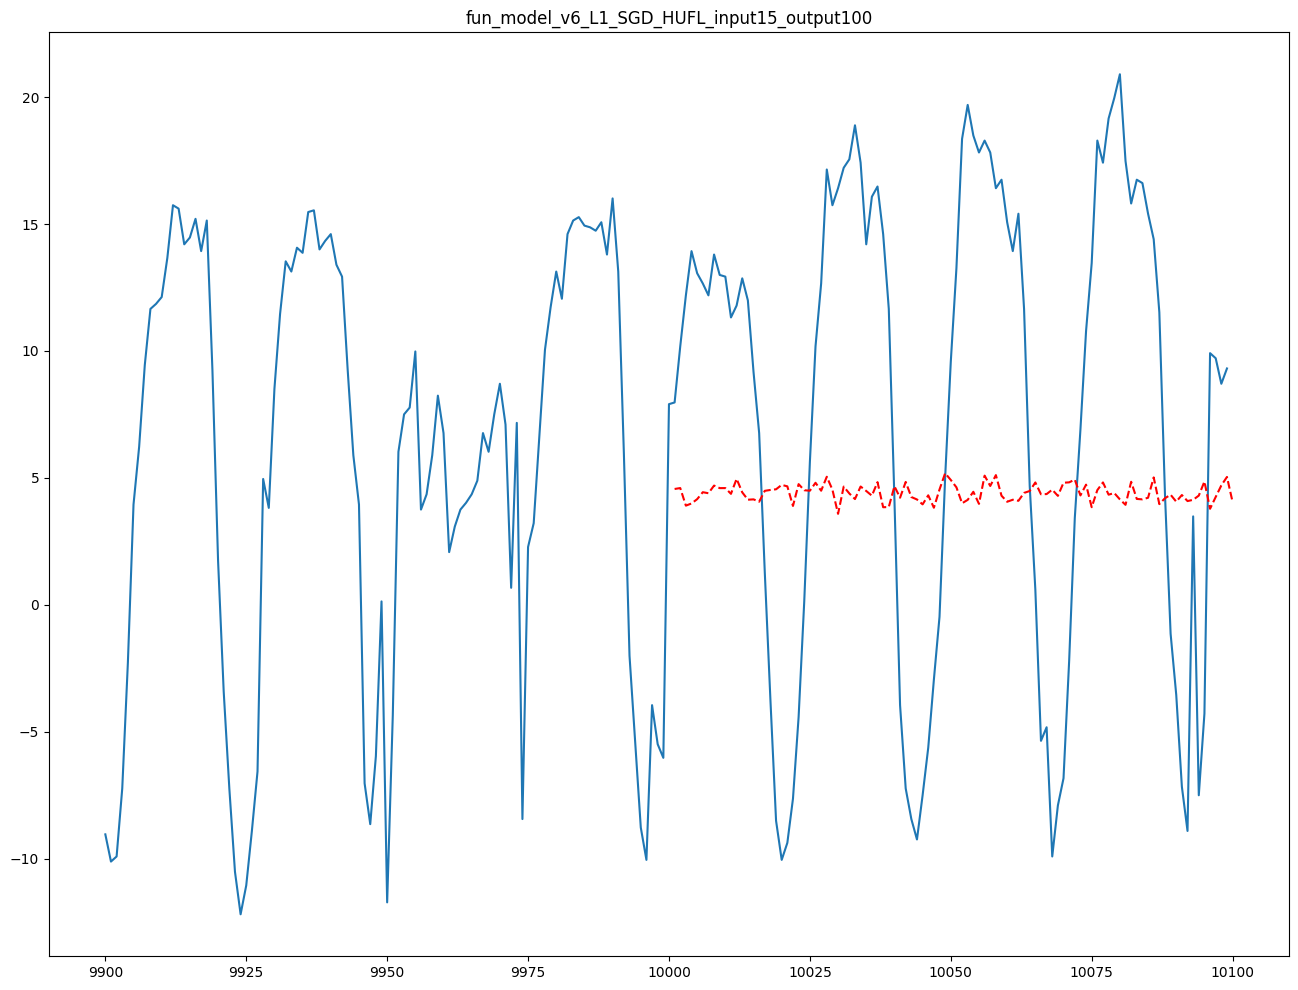

In [99]:

print("Future Predictions:", future_predictions)
time = [data_set-output_size*step+i*step for i in range(2*output_size)]
print(output_size)
plt.rcParams["figure.figsize"] = (16,12)
plt.plot(time, data[column_name].values[data_set-output_size*step:data_set+(output_size)*step:step])
#plt.plot(, )
pred = data[column_name].values[data_set-1]
time = [data_set+1+i*step for i in range(output_size)]

    
plt.plot(time, future_predictions[::], 'r--')
plt.title(model_name)
plt.show()
#plt.savefig(model_name+"2", dpi=1000)




In [100]:
i = [data_set+1+i*step for i in range(output_size)]

import numpy as np

actual = np.array([data[column_name].values[k] for k in i])
prediction = np.array(future_predictions)

l1_loss = abs(actual - prediction)

"""
Output:
[0 1 2 2]
"""

mae_cost = l1_loss.mean()
print(mae_cost)

9.147434742748738
